# Transfer Learning Face2Face
We present there a fake detection task on Face2Face manipulation, performed with the use of a pre-trained **Xception model**. We try to evaluate the performance of the network for this task in two different situation:

*   Going to take the weights of the pretrained model as intial weigths and fine-tuning the pre-trained *Xception model* on the *Face2Face dataset*
*   Freezing the weights of all the layer of the pretrained model and going to add, as last layer, a combination of two Linear layers with a ReLu activation function, which is the only one retrained on the *Face2Face dataset*.

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 8.8 MB/s eta 0:00:00


#IMPORT

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
#import pretrainedmodels
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import timm
import time
import os
import copy
from PIL import Image
import random
import cv2
import pandas as pd
from google.colab import drive

cudnn.benchmark = True
plt.ion()   # interactive mode

#Load Data


##Folder

In [ ]:
drive.mount('/content/drive/')
data_dir = '/content/drive/MyDrive/VISIOPE_PROJECT/DataVisionSet_face2face/' #For training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive/


#DataLoader with augmentation and normalization

In the following block, we create the ImageFolder (one for the train and one for the validation set), and the dataloaders, necessary for the training phase.
In particular we make a data augmentation on the Train dataset, going to apply a RandomRotation of 15 degrees, and we create batches of 4 images.

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(15),  
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [ ]:
print('Number of file in train set: '+ str(len(image_datasets['train'])))
print('Number of file in val set: '+ str(len(image_datasets['val'])))

Number of file in train set: 1600
Number of file in val set: 200


In [ ]:
print('Number of batches in train dataloader: '+ str(len(dataloaders['train'])))
print('Number of batches in val dataloader: '+ str(len(dataloaders['val'])))

Number of batches in train dataloader: 400
Number of batches in val dataloader: 50


#Visualize a few images

`imshow` allows us to print some examples of images present of one batch, taken randomly.

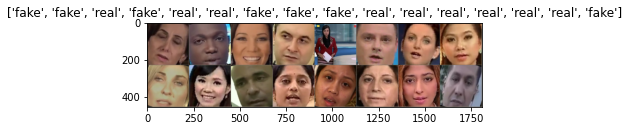

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# FINETUNING XCEPTION




> For perform our binary classification task, we use a **Xception Network**.It is a Deep Convolutional Neural Network devolped by Google in 2016. It reaches the *'state-of-art'* in different typicall task of the Computer Vision, such as Object detection, Object classification and so on, thank to the use of *depthwise separable convolutional layers*, which allow the network to learn spatial hierarchies at multiple scales.



##Xception


> In this situation, we create a pre-trained *Xception model*, trained on Imagenet, named `model_ft`, and we retrain it on the Face2Face dataset.
There, we use an *Adam optimizer*, with a initial learning rate really low ( `lr=0.00001`) with a *CosineAnnealingLR scheduler* to avoid Validation loss oscillation.



In [ ]:
model_ft = timm.create_model('xception', pretrained=True)
#model_ft

In [ ]:
num_ftrs = model_ft.fc.in_features


model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(),lr=0.00001, betas=(0.6,0.999)) 

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)    #each 7 epochs it reduces the learning rate of 0.1*lr
exp_lr_scheduler= lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=50, eta_min=1e-7)

In [ ]:
model_ft

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

## FINETUNING XCEPTION FREEZING INITIAL LAYERS


> In this situation instead, we create a Xception pre-trained model, `model_ft_freeze`, we freeze all the weigths of the network and finally we add a `nn.Sequential` composed of two linear layers with a Relu in between.

For this case, we use an *SGD optimezer* with an *StepLR scheduler* which decrease the learning rate every 7 epochs.



In [ ]:
model_ft_freeze = timm.create_model('xception', pretrained=True)
#model_ft_freeze

In [ ]:
for param in model_ft_freeze.parameters():
    param.requiresGrad = False


num_ftrs = model_ft_freeze.fc.in_features


model_ft_freeze.last_linear = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    #nn.Dropout(p=0.5),
    nn.Linear(512, 2) 
)

#model_ft_freeze.fc = nn.Linear(num_ftrs, 2)

model_ft_freeze = model_ft_freeze.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft_freeze.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft_freeze

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

# Define train_model function

We defined the train function. In this is also implemented a *early stopping method* to avoid the overfitting of the model. 

The `patience` is the hyperparameter which establishes after how many consecutive epochs of increase in valid loss the training phase must stop.
It is by default set to 3.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=3):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss=[]
    val_loss=[]

    train_acc=[]
    val_acc=[]

    counter=0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

           
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                
                #forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':     
              scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Define early stopping
            if epoch>0 and phase=='val' and epoch_loss>=val_loss[-1]:
              counter+=1
            else:
              counter=0


            if phase=='train':
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc.item())
            else:
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc.item())

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        #Evaluate patience for early stopping
        if counter == patience:
          print("Early stopping")
          break

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return {'model': model, 'train_loss':train_loss, 'val_loss':val_loss, 'train_acc': train_acc, 'val_acc': val_acc}


# Visualizing the model predictions

Generic function to display predictions for a few images



In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} -- effective: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Train and evaluate


### Train model NO freeze

In [ ]:
model_train = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50, patience=3)

Epoch 0/49
----------
train Loss: 0.6736 Acc: 0.5981
val Loss: 0.6165 Acc: 0.7650

Epoch 1/49
----------
train Loss: 0.5539 Acc: 0.7506
val Loss: 0.3666 Acc: 0.8850

Epoch 2/49
----------
train Loss: 0.4193 Acc: 0.8131
val Loss: 0.3005 Acc: 0.8950

Epoch 3/49
----------
train Loss: 0.3670 Acc: 0.8375
val Loss: 0.2502 Acc: 0.9450

Epoch 4/49
----------
train Loss: 0.3526 Acc: 0.8469
val Loss: 0.2235 Acc: 0.9600

Epoch 5/49
----------
train Loss: 0.3209 Acc: 0.8638
val Loss: 0.2147 Acc: 0.9400

Epoch 6/49
----------
train Loss: 0.3211 Acc: 0.8550
val Loss: 0.1926 Acc: 0.9650

Epoch 7/49
----------
train Loss: 0.2937 Acc: 0.8762
val Loss: 0.1637 Acc: 0.9550

Epoch 8/49
----------
train Loss: 0.2784 Acc: 0.8825
val Loss: 0.1489 Acc: 0.9550

Epoch 9/49
----------
train Loss: 0.2720 Acc: 0.8881
val Loss: 0.1602 Acc: 0.9600

Epoch 10/49
----------
train Loss: 0.2514 Acc: 0.8938
val Loss: 0.1493 Acc: 0.9550

Epoch 11/49
----------
train Loss: 0.2503 Acc: 0.9031
val Loss: 0.1283 Acc: 0.9700

Ep

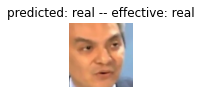

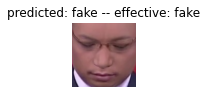

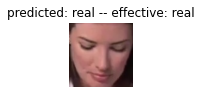

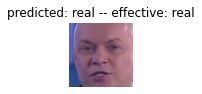

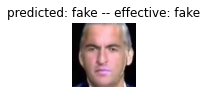

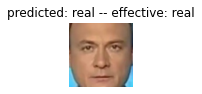

In [ ]:
visualize_model(model_train['model'])

plt.ioff()
plt.show()

# Plot Train Loss and Accuracy



> In this section we plot the `training` and `validation loss` and the `accuracy` of our model without freezing


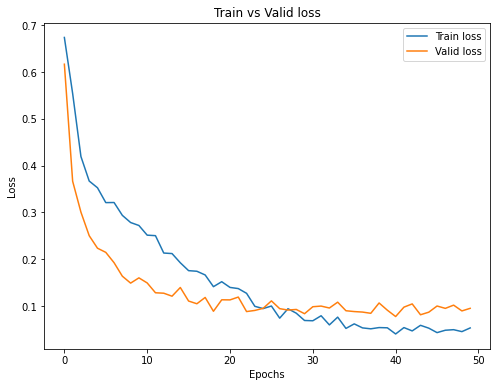

In [ ]:
def plot_logs(train_loss, valid_loss, title: str):

    plt.figure(figsize=(8,6))

    plt.plot(list(range(len(train_loss))), train_loss, label='Train loss')
    plt.plot(list(range(len(valid_loss))), valid_loss, label='Valid loss')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")

    plt.show()

plot_logs(model_train['train_loss'], model_train['val_loss'], 'Train vs Valid loss')

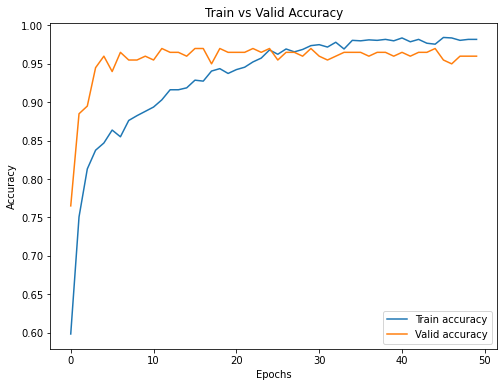

In [ ]:
def plot_acc(train_acc, valid_acc, title: str):

    plt.figure(figsize=(8,6))

    plt.plot(list(range(len(train_acc))), train_acc, label='Train accuracy')
    plt.plot(list(range(len(valid_acc))), valid_acc, label='Valid accuracy')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc="lower right")

    plt.show()

plot_acc(model_train['train_acc'], model_train['val_acc'], 'Train vs Valid Accuracy')

## Train model freeze

In [ ]:
model_train_freeze = train_model(model_ft_freeze, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.9654 Acc: 0.6494
val Loss: 0.3737 Acc: 0.8600

Epoch 1/49
----------
train Loss: 0.3784 Acc: 0.8300
val Loss: 0.2430 Acc: 0.9050

Epoch 2/49
----------
train Loss: 0.3055 Acc: 0.8662
val Loss: 0.2566 Acc: 0.9350

Epoch 3/49
----------
train Loss: 0.2251 Acc: 0.9044
val Loss: 0.2050 Acc: 0.9250

Epoch 4/49
----------
train Loss: 0.1659 Acc: 0.9337
val Loss: 0.1817 Acc: 0.9350

Epoch 5/49
----------
train Loss: 0.1250 Acc: 0.9556
val Loss: 0.1225 Acc: 0.9550

Epoch 6/49
----------
train Loss: 0.0974 Acc: 0.9663
val Loss: 0.1200 Acc: 0.9600

Epoch 7/49
----------
train Loss: 0.0803 Acc: 0.9725
val Loss: 0.1298 Acc: 0.9600

Epoch 8/49
----------
train Loss: 0.0723 Acc: 0.9744
val Loss: 0.1243 Acc: 0.9750

Epoch 9/49
----------
train Loss: 0.0622 Acc: 0.9775
val Loss: 0.1265 Acc: 0.9650

Epoch 10/49
----------
train Loss: 0.0587 Acc: 0.9775
val Loss: 0.1389 Acc: 0.9550

Epoch 11/49
----------
train Loss: 0.0561 Acc: 0.9794
val Loss: 0.1228 Acc: 0.9500

Ep

# Plot Train Loss and Accuracy



> In this section we plot the `training` and `validation loss` and the `accuracy` of our model with freezing layers


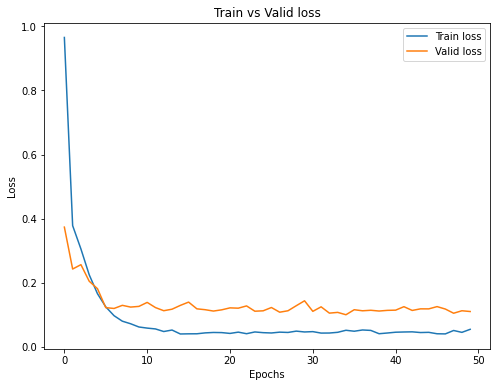

In [ ]:
def plot_logs(train_loss, valid_loss, title: str):

    plt.figure(figsize=(8,6))

    plt.plot(list(range(len(train_loss))), train_loss, label='Train loss')
    plt.plot(list(range(len(valid_loss))), valid_loss, label='Valid loss')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")

    plt.show()

plot_logs(model_train_freeze['train_loss'], model_train_freeze['val_loss'], 'Train vs Valid loss')

In [ ]:
model_train_freeze['train_acc']=[tensor.item() for tensor in model_train_freeze['train_acc']]
model_train_freeze['val_acc']=[tensor.item() for tensor in model_train_freeze['val_acc']]

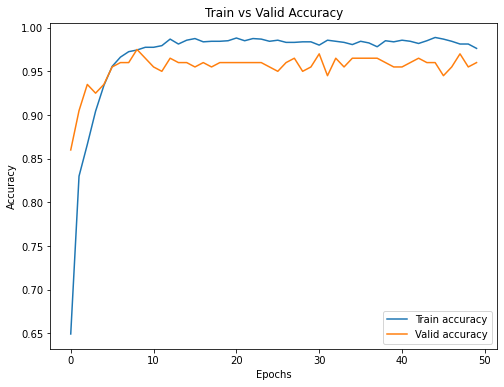

In [ ]:
def plot_acc(train_acc, valid_acc, title: str):

    plt.figure(figsize=(8,6))

    plt.plot(list(range(len(train_acc))), train_acc, label='Train accuracy')
    plt.plot(list(range(len(valid_acc))), valid_acc, label='Valid accuracy')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc="lower right")

    plt.show()

plot_acc(model_train_freeze['train_acc'], model_train_freeze['val_acc'], 'Train vs Valid Accuracy')

#Save Model

In [ ]:
%cd /content/drive/MyDrive/VISIOPE_PROJECT/models

/content/drive/.shortcut-targets-by-id/1SD-LhXJK1ufMgPEQVdrk_U7c2Xa0_bCF/VISIOPE_PROJECT/models


## Model Not Freeze

In [ ]:
torch.save(model_train['model'].state_dict(), 'xception_face2face_50epochs_Adam_NORMAL_Def.pt')

## Model Freeze

In [ ]:
torch.save(model_train_freeze['model'].state_dict(), 'xception_face2face_50epochs_FREEZE_Def.pt')